In [12]:
import tdmclient.notebook
await tdmclient.notebook.start()

NodeLockError: Node lock error (current status: busy)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pygame as pg
import sys

from kalman import Kalman
from kalman import move, drawLine

In [13]:
@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500):
    """
    Sets the motor speeds of the Thymio
    param l_speed: left motor speed
    param r_speed: right motor speed
    """
    global motor_left_target, motor_right_target

    motor_left_target = l_speed
    motor_right_target = r_speed

In [14]:
@tdmclient.notebook.sync_var
def read_motors():
    """
    Read the motor speeds of the Thymio
    """
    global motor_left_speed, motor_right_speed

    return [motor_left_speed, motor_right_speed]

In [16]:
# Initialize pygame
pg.init()

h = 600
w = 800
scr = pg.display.set_mode((w, h))

thymio = pg.image.load("thymio.png")
thymio = pg.transform.scale(thymio, (50, 50))

# Set simulation parameters
Ts = 0.01
NUM_STEPS = 300
MEAS_EVERY_STEPS = 10

# Initialize kalman filter
xhat_pos = [0, 0, 0, 0] # Initial pose estimate
xhat_att = [0, 0]       # Initial attitude estimate
kf_pos = Kalman(init_x=xhat_pos, _acc_variance=0.5, _type="pose")
kf_att = Kalman(init_x=xhat_att, _acc_variance=0.5, _type="orientation")

meas_variance_pos = np.array([[0.01, 0],
                              [0, 0.01]])
meas_variance_vel = np.array([[0.01, 0],
                              [0, 0.01]])
meas_variance_att = np.array([0.001])
meas_variance_omega = np.array([0.1])

mus_pos = []
covs_pos = []
mus_att = []
covs_att = []

# main loop
step = 0
running = True
simulate = False
while running:
    for event in pg.event.get():
        if event.type == pg.QUIT:
            pg.quit()
            sys.exit()
        elif event.type == pg.KEYDOWN:
            if event.key == pg.K_RETURN :
                simulate = not simulate
    # Set up environment
    scr.fill((0, 0, 0))
    pg.draw.line(scr, (255, 255, 255), (0, int(h/2)), (w, int(h/2)))
    pg.draw.line(scr, (255, 255, 255), (int(w/2), 0), (int(w/2), h))

    # Start simulation
    if simulate:
        step+=1

        # Save expected values and covariance matrices
        mus_pos.append(kf_pos.mean)
        covs_pos.append(kf_pos.cov)
        mus_att.append(kf_att.mean)
        covs_att.append(kf_att.cov)

        # Read sensor data
        motor_speeds = read_motors()
        speed = (sum(motor_speeds)/2)*0.0005 # magnitude of velocity [m/s]
        angular_speed = (motor_speeds[1]-motor_speeds[0])*0.0005/0.094 # magnitude of angular velocity [rad/s]
        velocity = [speed*np.cos(mus_att[-1][0]), speed*np.sin(mus_att[-1][0])]

        # Estimate pose
        kf_pos.predict(dt=Ts)
        kf_pos.update(meas_value=velocity,
                meas_variance=meas_variance_vel,
                C=np.array([[0, 0, 1, 0], [0, 0, 0, 1]]))

        # Estimate orientation
        kf_att.predict(dt=Ts)
        kf_att.update(meas_value=angular_speed,
                meas_variance=meas_variance_omega,
                C=np.array([0, 1]))

        # Update thymio position
        move(kf_pos.mean[0], kf_pos.mean[1], kf_att.mean[0], w, h, thymio, scr)
        drawLine([mu[0] for mu in mus_pos], [mu[1] for mu in mus_pos], w, h, scr)

        # Flow control
        if step > 100:
            motors(-200, 200)
    else:
        move(kf_pos.mean[0], kf_pos.mean[1], kf_att.mean[0], w, h, thymio, scr)
        motors(0, 0)

    # Update screen
    pg.display.flip()
    time.sleep(Ts)

motors(0, 0)

SystemExit: 

In [ ]:

stop()


NameError: name 'Ts' is not defined

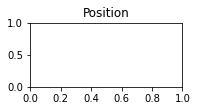

In [9]:
plt.figure(1)

plt.subplot(3, 2, 1)
plt.title("Position")
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[0] for mu in mus_pos], 'r')
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[0] - np.sqrt(cov[0, 0]) for mu, cov in zip(mus_pos, covs_pos)], 'r--')
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[0] + np.sqrt(cov[0, 0]) for mu, cov in zip(mus_pos, covs_pos)], 'r--')
plt.grid()

plt.subplot(3, 2, 2)
plt.title("Position")
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[1] for mu in mus_pos], 'r')
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[1] - np.sqrt(cov[1, 1]) for mu, cov in zip(mus_pos, covs_pos)], 'r--')
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[1] + np.sqrt(cov[1, 1]) for mu, cov in zip(mus_pos, covs_pos)], 'r--')
plt.grid()

plt.subplot(3, 2, 3)
plt.title("Velocity")
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[2] for mu in mus_pos], 'r')
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[2] - np.sqrt(cov[2, 2]) for mu, cov in zip(mus_pos, covs_pos)], 'r--')
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[2] + np.sqrt(cov[2, 2]) for mu, cov in zip(mus_pos, covs_pos)], 'r--')
plt.grid()

plt.subplot(3, 2, 4)
plt.title("Velocity")
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[3] for mu in mus_pos], 'r')
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[3] - np.sqrt(cov[3, 3]) for mu, cov in zip(mus_pos, covs_pos)], 'r--')
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[3] + np.sqrt(cov[3, 3]) for mu, cov in zip(mus_pos, covs_pos)], 'r--')
plt.grid()

plt.subplot(3, 2, 5)
plt.title("Orientation")
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[0] for mu in mus_att], 'r')
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[0] - np.sqrt(cov[0, 0]) for mu, cov in zip(mus_att, covs_att)], 'r--')
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[0] + np.sqrt(cov[0, 0]) for mu, cov in zip(mus_att, covs_att)], 'r--')
plt.grid()

plt.subplot(3, 2, 6)
plt.title("Angular Velocity")
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[1] for mu in mus_att], 'r')
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[1] - np.sqrt(cov[1, 1]) for mu, cov in zip(mus_att, covs_att)], 'r--')
plt.plot(Ts * np.arange(0, NUM_STEPS, 1), [mu[1] + np.sqrt(cov[1, 1]) for mu, cov in zip(mus_att, covs_att)], 'r--')
plt.grid()

plt.tight_layout()

plt.show()

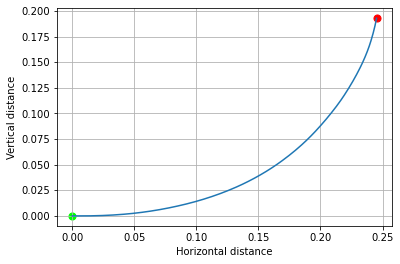

In [197]:
plt.figure(2)
plt.plot([mu[0] for mu in mus_pos], [mu[1] for mu in mus_pos])
plt.scatter(mus_pos[0][0],mus_pos[0][1], s=50, c=[[0,1,0]])
plt.scatter(mus_pos[-1][0],mus_pos[-1][1], s=50, c=[[1,0,0]])
plt.xlabel("Horizontal distance")
plt.ylabel("Vertical distance")
plt.grid()

In [198]:
print(mus_pos[-1][0])
print(mus_att[-1][0])

0.24514055841161791
1.4328252856744288
